In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 217.9 kB/s eta 0:09:34
   ---------------------------------------- 0.1/124.9 MB 328.6 kB/s eta 0:06:20
   ---------------------------------------- 0.1/124.9 MB 481.4 kB/s eta 0:04:20
   ---------------------------------------- 0.2/124.9 MB 655.1 kB/s eta 0:03:11
   ---------------------------------------- 0.3/124.9 MB 803.7 kB/s eta 0:02:36
   ---------------------------------------- 0.3/124.9 MB 901.1 kB/s eta 0:02:19
   ---------------------------------------- 0.5/124.9 MB 1.2 MB/s eta 0:01:41
   ---------------------------------------- 0.6/124.9 MB 1.3 MB/s eta 0:01:35
  

In [121]:
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
import pandas as pd 


In [122]:
df = pd.read_csv("datasets/user_fake_authentic_4class.csv")

In [123]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

In [124]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [125]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [126]:
y_train = df_train['class']
y_val = df_val['class']
y_test = df_test['class']

In [127]:
del df_train['class']
del df_val['class']
del df_test['class']

In [128]:
df['class'].value_counts()

class
0    12054
1    10549
2    10441
3    10263
Name: count, dtype: int64

In [129]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [130]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [131]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [132]:
# Revisar las primeras filas de X_train
print(pd.DataFrame(X_train).head())

# Verificar el tipo de cada columna
print(pd.DataFrame(X_train).dtypes)

# Verificar si hay valores no numéricos
non_numeric_columns = [col for col in pd.DataFrame(X_train).columns if pd.DataFrame(X_train)[col].dtype == 'object']
print("Columns with non-numeric values:", non_numeric_columns)

      0      1         2         3     4      5       6       7      8   \
0  158.0   80.0  0.012885  0.000000  0.09   1.57  1900.0  1200.0  0.111   
1   60.0   55.0  0.018878  0.111111  0.06   2.53  1700.0   680.0  0.000   
2    0.0   39.0  0.177073  0.437500  0.40   7.19   864.0   232.0  0.000   
3  176.0  488.0  0.279964  0.444444  0.01   0.16  2200.0   781.0  0.167   
4   62.0   23.0  0.026948  0.166667  0.60  17.84  2600.0   791.0  0.000   

      9    10     11     12           13   14     15     16  
0  1.167  0.0  0.167  0.278   132.152924  1.0  167.0  0.056  
1  0.500  0.0  0.500  0.222   278.589691  1.0  132.0  0.000  
2  0.313  0.0  0.188  0.125  1511.267822  1.0   16.0  0.063  
3  0.333  0.0  0.333  0.111    44.142933  1.0  696.0  0.833  
4  0.056  0.0  0.056  0.389   342.595947  1.0   36.0  0.000  
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    flo

In [133]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [152]:
xgb_params = {
    'eta': 0.8, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softprob',  # Cambiado a multi:softmax
    'num_class': 4,  # Número de clases 
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [153]:
y_pred = model.predict(dval)

In [154]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.9911791693997674

In [155]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [169]:
%%capture output

xgb_params = {
    'eta': 0.9, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softprob',  # Cambiado a multi:softmax
    'num_class': 4,  # Número de clases 
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
    
    'eval_metric': 'auc',

}

model = xgb.train(xgb_params, dtrain, num_boost_round=40,
                  verbose_eval=5,
                  evals=watchlist)

In [170]:
s = output.stdout

In [171]:
s

'[0]\ttrain-auc:0.98295\tval-auc:0.98145\n[5]\ttrain-auc:0.99376\tval-auc:0.99034\n[10]\ttrain-auc:0.99682\tval-auc:0.99173\n[15]\ttrain-auc:0.99843\tval-auc:0.99199\n[20]\ttrain-auc:0.99934\tval-auc:0.99219\n[25]\ttrain-auc:0.99963\tval-auc:0.99233\n[30]\ttrain-auc:0.99987\tval-auc:0.99231\n[35]\ttrain-auc:0.99994\tval-auc:0.99229\n[39]\ttrain-auc:0.99998\tval-auc:0.99217\n'

In [172]:
print(s[:200])

[0]	train-auc:0.98295	val-auc:0.98145
[5]	train-auc:0.99376	val-auc:0.99034
[10]	train-auc:0.99682	val-auc:0.99173
[15]	train-auc:0.99843	val-auc:0.99199
[20]	train-auc:0.99934	val-auc:0.99219
[25]	tr


In [173]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [174]:
df_score = parse_xgb_output(output)

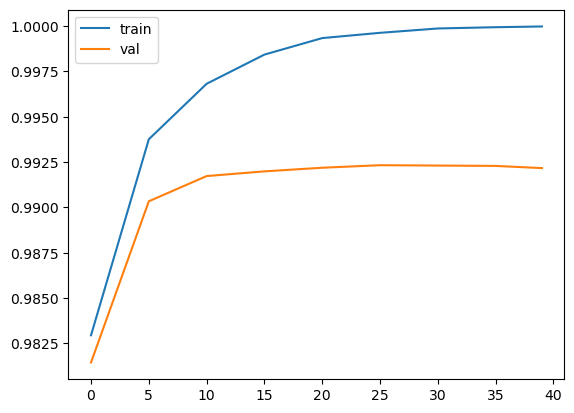

In [175]:
import matplotlib.pyplot as plt
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

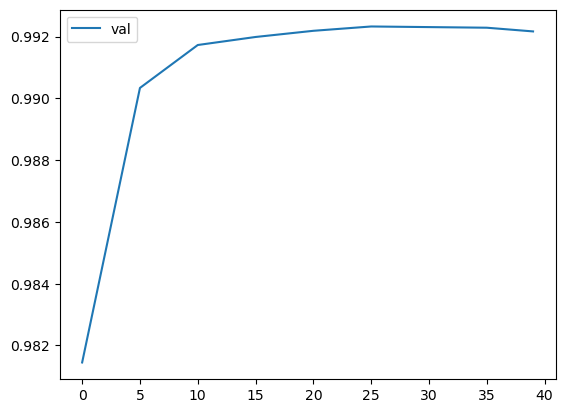

In [176]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [177]:
print(pd.Series(y_train).value_counts())


class
0    7274
1    6318
2    6247
3    6144
Name: count, dtype: int64


Train AUC:  0.9999819692523363
Validation AUC:  0.9919919303876492


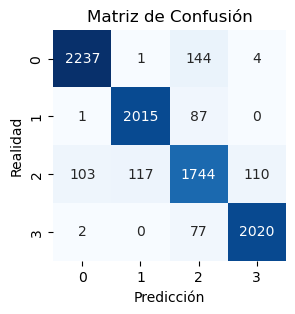

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Realizar predicciones
y_pred = model.predict(dval)  # Predicciones para el conjunto de validación

# Obtener las probabilidades para el conjunto de entrenamiento
y_pred_train = model.predict(dtrain)  # Esto también da las probabilidades para las clases

# Calcular AUC para el conjunto de entrenamiento
train_auc = roc_auc_score(y_train, y_pred_train, multi_class='ovr')
print("Train AUC: ", train_auc)

# AUC para el conjunto de validación
y_pred_val = model.predict(dval)  # Predicciones para el conjunto de validación
val_auc = roc_auc_score(y_val, y_pred_val, multi_class='ovr')
print("Validation AUC: ", val_auc)

# Crear la matriz de confusión
cm = confusion_matrix(y_val, y_pred.argmax(axis=1))  # Cambia 'y_pred' a las clases más altas

# Graficar la matriz de confusión
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Personalizar el gráfico
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

* `eta`
* `max_depth`
* `min_child_weight`

In [111]:
scores = {}

In [112]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'multi:softprob',  # Cambiado a multi:softmax
    'num_class': 4,  # Número de clases 
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [113]:
scores = {}

In [114]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [115]:
scores = {}

In [116]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'multi:softprob',  # Cambiado a multi:softmax
    'num_class': 4,  # Número de clases ,
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [117]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [118]:
del scores['max_depth=10']

In [120]:
scores

{}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


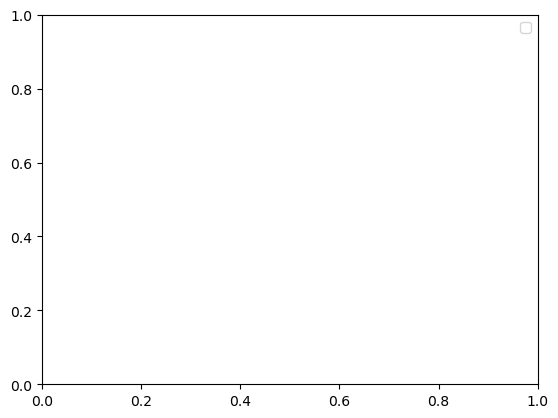

In [119]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

# plt.ylim(0.8, 1.4)
plt.legend()